<a href="https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7/blob/nguyenthiman/try_word2vec_Skip-gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 7:
1. 18120429 – Phạm Trung Kiên - trungkien2000
2. 18120431 – A Ly Ha Kim - kim-ali
3. 18120434 – Thái Hoàng Lâm - hoanglam372000
4. 18120462 – Nguyễn Thị Mận - ManCB26
Link thùng chứa Github của nhóm:
https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7

# I. Mô tả bài toán: 
## 1. Mô tả:
Link: https://www.kaggle.com/c/tweet-sentiment-extraction \

- Bài toán thuộc lĩnh vực NLP, cụ thể là bài toán phân tích cảm xúc (Sentiment Analysis)
- Không giống như những bài toán phân tích cảm xúc khác chỉ dừng ở việc phân lớp, bài toán yêu cầu phải rút trích những từ ngữ trong câu đóng góp cho cảm xúc tương ứng.
- Ví dụ: "I am happy": positive -> "happy" \

## 2. Hướng giải quyết của nhóm 
Ban đầu nhóm định theo hướng giải quyết của người đứng hạng 3 trên private leaderboard, đó là sử dụng RoBerta. Tuy nhiên, với trình độ hiện tại của các bạn trong nhóm thì phương pháp này đang vượt quá tầm với vì vậy phương hướng tiếp cận của nhóm đã vẽ ra như sau:

- Nhóm tiến hành giải bài toán theo cách riêng của nhóm: Học thống kê \
- Sau khi ra kết quả training, nếu chưa đạt được kết quả nằm trong top 20 của private leaderboard, thì nhóm sẽ tiếp tục tiếp cận dần các phương pháp Deep learning \
- Sau cùng, nếu vẫn chưa đạt được kết quả khả quan với những kiến thức deep learning đã học, nhóm sẽ tiến hành giải tiếp bài toán theo phương pháp của hạng 3 (lúc này các thành viên đã đủ kiến thức)




# II. Giải quyết bài toán và cài đặt:

# 1. Học dựa trên thống kê

- Tiền xử lý và khám phá dữ liệu
- Xây dựng từ điển tần suất theo sentiment
- Xây dựng Bag-of-word theo xác suất Naive-Bayes
- Trích text bằng likelihood của bước trên và ước lượng ngưỡng
- Ánh xạ text đã rút trích về nguyên mẫu của từng từ trong text (đề yêu cầu)
- Đánh giá bằng độ đo Jaccard Similarity
- Tunning trên tập val để tìm siêu tham số tốt nhất
- Dự đoán rút trích trên tập test
 

### 1.1 Lấy dữ liệu, Khám phá và tiền xử lý:

#### 1.1.1 Thư viện:

In [ ]:
!git clone https://github.com/hoanglam372000/Applied-Data-Science-Group-7.git

fatal: destination path 'Applied-Data-Science-Group-7' already exists and is not an empty directory.


In [ ]:
!pip install emoji
!pip install pyenchant
#!pip install pycontractions

In [ ]:
import math
import pandas as pd
import nltk
import numpy as np
import emoji
#import contractions
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as st
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint
#print(stopwords.words('english'))
pd.set_option('display.max_colwidth', 200)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('names')
names = nltk.corpus.names.words('male.txt')+nltk.corpus.names.words('female.txt')
names_lower = [name.lower() for name in names]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [ ]:
!pip install afinn

In [ ]:
from afinn import Afinn
afinn = Afinn(language='en')

#### 1.1.2 Khám phá dữ liệu

In [ ]:
df = pd.read_csv('Applied-Data-Science-Group-7/train.csv')

In [ ]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


#### 1.1.3 Tách tập dữ liệu

In [ ]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 70%:30%
X_df = df.drop(labels = 'selected_text',axis = 1)
y_ex = df.selected_text
y_class = df.sentiment
train_X_df, val_X_df, train_y_ex, val_y_ex = train_test_split(X_df, y_ex, test_size=0.3, 
                                                              stratify=y_class, random_state=0)

In [ ]:
print('train_X: ',train_X_df.shape)
print('train_y: ',train_y_ex.shape)
print('val_X: ',val_X_df.shape)
print('val_y: ',val_y_ex.shape)


train_X:  (19236, 3)
train_y:  (19236,)
val_X:  (8244, 3)
val_y:  (8244,)


### 1.2 Tiền xử lý + Khám phá tập train

#### 1.2.1 Khám phá tập train

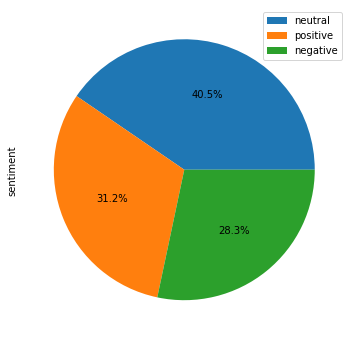

In [ ]:
#Phân bố của các lớp:
train_X_df.sentiment.value_counts(normalize= True).plot(kind="pie",labels = None, legend='auto', figsize=(8,6), autopct="%.1f%%");

In [ ]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19236 entries, 652 to 12238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     19236 non-null  object
 1   text       19236 non-null  object
 2   sentiment  19236 non-null  object
dtypes: object(3)
memory usage: 601.1+ KB


In [ ]:
train_X_df.duplicated().sum()

0

In [ ]:
train_y_ex.isnull().sum()

0

#### 1.2.2 Tiền xử lý văn bản

In [ ]:
 #nltk.pos_tag(['i','am','over','the','moon'])

In [ ]:
# import enchant
# from nltk.metrics import edit_distance
# class SpellingReplacer(object):
#     def __init__(self, dict_name='en', max_dist=2):
#         self.spell_dict = enchant.Dict(dict_name)
#         self.max_dist = max_dist
#     def replace(self, word):
#         if self.spell_dict.check(word):
#             return word
#         suggestions = self.spell_dict.suggest(word)
#         if suggestions and edit_distance(word, suggestions[0]) <=self.max_dist:
#             return suggestions[0]
#         else:
#             return word
# replacer = SpellingReplacer()
# replacer.replace('cookbok')

In [ ]:
stemmer = PorterStemmer()
# class xử lý vấn đề trùng ký tự trong từ, ví dụ yoooouuuu -> you, nooooo -> no.
#sử dụng pattern của regular expression, tuy nhiên phải quét thêm qua wordnet để tránh trường hợp như từ goose bị chuyển thành gose (mặc dù goose là từ đúng)
class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
    def replace(self, word):
        if wordnet.synsets(word):
            return word
        repl_word = self.repeat_regexp.sub(self.repl, word)
        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word
char_repeat_correct = RepeatReplacer()
def preprocessing_word(word):
  
  if word != emoji.demojize(word):
    return emoji.demojize(word)
  #word = contractions.fix(word)
  #word = stemmer.stem(word)
  
  temp=[ "html_tag",'URL','HIDDEN','tag',"hash_tag"]
  if word in temp:
    return word
  #số theo từ
  if word.isdigit():  
    return 'NUMBER'
  try: 
    float(word)
    return 'NUMBER'
  except:
    pass


  #word=word.lower() # viết thườngthường
  #spell_corrector = Speller(lang='en') #sửa chính tả theo từng từ 
  #word=spell_corrector(word)

  # rút gọn theo từ
  #lemmatizer = WordNetLemmatizer()
  #wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
  #pos_tagged = nltk.pos_tag(word.split())
  
  #word = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged]
  #word = ' '.join(word)

  #word=word.translate(str.maketrans('', '', string.punctuation)) # chấm câu theo từ (vì tránh emoij)
  word = re.sub(pattern=r'["!\.#$%&\'()*+-/:;<=>@\?\[\]^_`{|}~0-9ï¿½]+', repl='', string=word)
  word = char_repeat_correct.replace(word)
  #word = stemmer.stem(word)
  #if (word in  names):
   # return '<Name>'
  word = stemmer.stem(word)
  word = word.lower()
  
  if word==''or word ==' ':
    return "Special"
  
  # if 'not' not in word and len(word.split())!=1:
  #   return word.split()[0]+'_'
  return word.replace(' ','_')

def preprocessing_text(tweet,sentiment):
   raw_text = str(tweet).strip().replace('\n', ' ')#.lower()
   # emoij
   raw_text=emoji.demojize(raw_text)
   e_r=r':\w+_\w+:'
   emoij_list=re.findall(e_r,raw_text)
   for e in emoij_list:
     raw_text=raw_text.replace(e,' ' + emoji.emojize(e) + ' ') # "hi❤️👍"
   if sentiment !=0: 
     raw_text = re.sub(pattern=r'(?<=\w)(\.){2,}?(?=\w)', repl=' ', string=raw_text)
   new_tweet = raw_text.split()
   len_=len(new_tweet)
   index2word = { w:new_tweet[w] for w in range(len_)}
   #parser = BeautifulSoup(raw_text, "html.parser")
   #raw_text = parser.get_text(separator = "<html_tag>")
   raw_text = re.sub(pattern=r'https?://\S+|www\.\S+', repl='URL', string=raw_text)
   raw_text = re.sub(pattern='\*{3,}?', repl='HIDDEN', string=raw_text)
   raw_text = re.sub(pattern=r'@\w+', repl='tag', string=raw_text)
   raw_text = re.sub(pattern=r'#\w+', repl='hash_tag', string=raw_text)
   
   word_list=raw_text.split()
   return index2word,dict(zip([*range(len_)],map(preprocessing_word,word_list)))

In [ ]:
# Test:
tweet = ' My mom just texted.......me and told *ship* James that Rodney3 charlie wasï¿½ *** chasing?? and fireflies... in their :)) backyard. Awwwww I`m miss him!!! @hoanglam 123 ://    http://twitpic.com/66pn1'
tweet2 = 'nooooooooo'
index2word_temp,preprocessed_tweet_temp = preprocessing_text(tweet2,1)
print('index2word: ',index2word_temp)
print('preprocessed_tweet: ',preprocessed_tweet_temp)

index2word:  {0: 'nooooooooo'}
preprocessed_tweet:  {0: 'no'}


In [ ]:
char_repeat_correct.replace(':))))))')

':))))))'

In [ ]:

def preprocess_tweets(X_df):
  X_df = X_df.copy()
  raw_tweets = X_df.text.to_list()
  X_df.sentiment = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1})
  index2word_tweets = [] #list of dictionaries
  preprocessed_tweets = [] #list of dictionaries
  cleaned_texts = []
  for tweet,senti in zip(raw_tweets,X_df.sentiment.to_list()):
    index2word, preprocessed = preprocessing_text(tweet,senti)
    index2word_tweets.append(index2word)
    preprocessed_tweets.append(preprocessed)
    cleaned_texts.append(' '.join(list(preprocessed.values())))
  preprocessed_X_df = pd.DataFrame(data={'textID':X_df.textID,'index2word':index2word_tweets, 'preprocessed_texts':preprocessed_tweets,'sentiment':X_df.sentiment})
  cleaned_int2text_df = pd.DataFrame(data={'textID':X_df.textID,'Raw_text':X_df.text, 'Cleaned_texts':cleaned_texts,'sentiment':X_df.sentiment})
  return preprocessed_X_df,cleaned_int2text_df

def _preprocessed_y_ex(X_df,y_ex):
  preprocessed_y_ex = []
  X_df = X_df.copy()
  cleaned_texts = []
  for tweet,senti in zip(y_ex.to_list(),X_df.sentiment.to_list()):
      index2word, preprocessed_y = preprocessing_text(tweet,senti)
      preprocessed_y_ex.append(preprocessed_y)
      cleaned_texts.append(' '.join(list(preprocessed_y.values())))

  X_df['sentiment'] = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1}).to_list()
  return pd.DataFrame(data = {'preprocessed_texts': preprocessed_y_ex,'Cleaned_text': cleaned_texts,'sentiment':X_df.sentiment})



In [ ]:
train_X_df.head(5)

,textID,text,sentiment
652,a834cef9c6,1st presentation for senior boards? FML,negative
24883,5bfad683d5,yummy curry save me some please lol,positive
15385,08a8d660b1,I wish I knew someone down there who could hook us up. a friend told me once that they got crappy seats for a show in CHI,negative
16753,99a0ff3bef,Lucky u Im stuck in the rain...,neutral
19,40e7becabf,Hes just not that into you,neutral


In [ ]:
#_preprocessed_y_ex(train_X_df.head(100),train_y_ex.head(100))

In [ ]:
# Test:
preprocessed_X_df_temp,cleaned_int2text_df_temp = preprocess_tweets(train_X_df.head(100))
preprocessed_X_df_temp

,textID,index2word,preprocessed_texts,sentiment
652,a834cef9c6,"{0: '1st', 1: 'presentation', 2: 'for', 3: 'senior', 4: 'boards?', 5: 'FML'}","{0: 'st', 1: 'present', 2: 'for', 3: 'senior', 4: 'board', 5: 'fml'}",-1
24883,5bfad683d5,"{0: 'yummy', 1: 'curry', 2: 'save', 3: 'me', 4: 'some', 5: 'please', 6: 'lol'}","{0: 'yummi', 1: 'curri', 2: 'save', 3: 'me', 4: 'some', 5: 'pleas', 6: 'lol'}",1
15385,08a8d660b1,"{0: 'I', 1: 'wish', 2: 'I', 3: 'knew', 4: 'someone', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up.', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'once', 17: 'that...","{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someon', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'onc', 17: 'that', ...",-1
16753,99a0ff3bef,"{0: 'Lucky', 1: 'u', 2: 'Im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain...'}","{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
19,40e7becabf,"{0: 'Hes', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}","{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
...,...,...,...,...
16799,82d211bdd5,"{0: 'i', 1: 'think', 2: 'i', 3: 'hate', 4: 'you.', 5: 'i', 6: 'didnt', 7: 'really', 8: 'want', 9: 'to', 10: 'but', 11: 'you', 12: 'make', 13: 'it', 14: 'hard', 15: 'for', 16: 'me', 17: 'to', 18: '...","{0: 'i', 1: 'think', 2: 'i', 3: 'hate', 4: 'you', 5: 'i', 6: 'didnt', 7: 'realli', 8: 'want', 9: 'to', 10: 'but', 11: 'you', 12: 'make', 13: 'it', 14: 'hard', 15: 'for', 16: 'me', 17: 'to', 18: 'l...",-1
6706,7a775cc933,"{0: 'If', 1: 'I', 2: 'were', 3: 'a', 4: 'transformer...', 5: 'I`d', 6: 'step', 7: 'on', 8: 'people', 9: 'just', 10: 'to', 11: 'hear', 12: 'them', 13: '*squoosh*.', 14: 'But', 15: 'I`m', 16: 'not',...","{0: 'if', 1: 'i', 2: 'were', 3: 'a', 4: 'transform', 5: 'id', 6: 'step', 7: 'on', 8: 'peopl', 9: 'just', 10: 'to', 11: 'hear', 12: 'them', 13: 'squosh', 14: 'but', 15: 'im', 16: 'not', 17: 'so', 1...",0
1967,127ac4d1d2,"{0: 'ohay', 1: 'clean', 2: 'teeth'}","{0: 'ohay', 1: 'clean', 2: 'teeth'}",1
9181,4b8cb4449b,"{0: 'Im', 1: 'fine', 2: 'also..up', 3: 'way', 4: 'to', 5: 'early..lol...soo', 6: 'those', 7: 'r', 8: 'all', 9: 'ur', 10: 'dogs?', 11: 'to', 12: 'kut3', 13: '..i', 14: 'def', 15: 'want', 16: 'a', 1...","{0: 'im', 1: 'fine', 2: 'alsoup', 3: 'way', 4: 'to', 5: 'earlylolso', 6: 'those', 7: 'r', 8: 'all', 9: 'ur', 10: 'dog', 11: 'to', 12: 'kut', 13: 'i', 14: 'def', 15: 'want', 16: 'a', 17: 'pit', 18:...",0


### 2. Mô hình hoá dữ liệu:

#### 2.1 Tiền xử lý:

In [ ]:
preprocessed_train_X, cleaned_train_X = preprocess_tweets(train_X_df)
preprocessed_train_y_ex = _preprocessed_y_ex(train_X_df,train_y_ex)
preprocessed_val_X, cleaned_val_X = preprocess_tweets(val_X_df)
preprocessed_val_y_ex = _preprocessed_y_ex(val_X_df,val_y_ex)

In [ ]:
#cleaned_train_X

In [ ]:
#pd.set_option('display.max_rows', df.shape[0]+1)
visual_df = pd.DataFrame(data ={'text':preprocessed_train_X.preprocessed_texts,'selected_text':preprocessed_train_y_ex.preprocessed_texts,'sentiment':preprocessed_train_X.sentiment})
visual_df.head(10)

,text,selected_text,sentiment
652,"{0: 'st', 1: 'present', 2: 'for', 3: 'senior', 4: 'board', 5: 'fml'}",{0: 'fml'},-1
24883,"{0: 'yummi', 1: 'curri', 2: 'save', 3: 'me', 4: 'some', 5: 'pleas', 6: 'lol'}",{0: 'yummi'},1
15385,"{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someon', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'onc', 17: 'that', ...","{0: 'p', 1: 'a', 2: 'friend', 3: 'told', 4: 'me', 5: 'onc', 6: 'that', 7: 'they', 8: 'got', 9: 'crappi', 10: 'seat', 11: 'for', 12: 'a', 13: 'show', 14: 'in'}",-1
16753,"{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}","{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
19,"{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}","{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
23126,"{0: 'gah', 1: 'Special', 2: 'thi', 3: 'weather', 4: 'sucksss', 5: 'Special'}","{0: 'gah', 1: 'Special', 2: 'thi', 3: 'weather', 4: 'sucksss', 5: 'Special'}",-1
27051,"{0: 'apolog', 1: 'dont', 2: 'fix', 3: 'hurt', 4: 'feel', 5: 'kev', 6: 'anyway', 7: 'ill', 8: 'get', 9: 'it', 10: 'from', 11: 'u', 12: 'next', 13: 'time', 14: 'i', 15: 'c', 16: 'u'}","{0: 'apolog', 1: 'dont', 2: 'fix', 3: 'hurt', 4: 'feel', 5: 'kev'}",-1
11314,"{0: 'Special', 1: 'follow', 2: 'my', 3: 'girl', 4: 'meagan'}","{0: 'Special', 1: 'follow', 2: 'my', 3: 'girl', 4: 'meagan'}",0
5854,"{0: 'thi', 1: 'is', 2: 'realli', 3: 'help', 4: 'you', 5: 'swear', 6: 'a', 7: 'lot', 8: 'i', 9: 'just', 10: 'realiz', 11: 'haha'}",{0: 'help'},1
8160,"{0: 'happi', 1: 'mother', 2: 'day', 3: 'x', 4: 'mum', 5: 'i', 6: 'love', 7: 'you'}",{0: 'happi'},1


In [ ]:
preprocessed_train_y_ex

,preprocessed_texts,Cleaned_text,sentiment
652,{0: 'fml'},fml,-1
24883,{0: 'yummi'},yummi,1
15385,"{0: 'p', 1: 'a', 2: 'friend', 3: 'told', 4: 'me', 5: 'onc', 6: 'that', 7: 'they', 8: 'got', 9: 'crappi', 10: 'seat', 11: 'for', 12: 'a', 13: 'show', 14: 'in'}",p a friend told me onc that they got crappi seat for a show in,-1
16753,"{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",lucki u im stuck in the rain,0
19,"{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",he just not that into you,0
...,...,...,...
21628,{0: 'best'},best,1
24747,"{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",yeah he also partial to jt and ti dead and gone and pink sobr,0
18164,"{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",oui i figur that sinc it a day off id better start brush up on my french so far i have learnt bonjour and oui,0
10041,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",if i can get a ticket but the pick are lokin slim so prob not,0


In [ ]:
# pd.set_option('display.max_rows', df.shape[0]+1)
neutral_df = visual_df.loc[visual_df.sentiment ==0,:]
#neutral_df
len_neutral_df = neutral_df.loc[:,['text','selected_text']].applymap(len)
index_neutral = len_neutral_df.loc[len_neutral_df.text == len_neutral_df.selected_text,:]
#cleaned_train_X.loc[index_neutral.index,:]
(index_neutral.shape[0]/ neutral_df.shape[0])*100
# pd.DataFrame(data ={'origin':cleaned_train_X.Raw_text,'text':cleaned_train_X.Cleaned_texts,'selected_text':preprocessed_train_y_ex.preprocessed_texts}).loc[index_neutral_diff.index,:]

88.02364430737599

In [ ]:
pos_df = visual_df.loc[visual_df.sentiment ==-1
                       ,:]
len_pos_df = pos_df.loc[:,['text','selected_text']].applymap(len)
# len_pos_df.selected_text.value_counts(normalize= True)*100
len_pos_df.loc[len_pos_df.selected_text == 1,:]

,text,selected_text
652,6,1
25356,3,1
9843,3,1
11309,13,1
724,7,1
...,...,...
12530,9,1
13957,8,1
2969,16,1
24444,21,1


In [ ]:
# pos_visual_df = visual_df.loc[visual_df.sentiment == 1,:]
# pos_visual_df.text.apply(len).max()

#### 2.2 Viết class và tinh chỉnh mô hình

##### 2.2.1 Sentiment Classification Class

In [ ]:
class Sentiment_Classification(object):
  def __init__(self,_max_depth = 3):
        #self.num_top_titles = num_top_titles
        self._max_depth = _max_depth
  def extract_features(self,tweet, likelihood):
    '''
    Input: 
        tweet: a dictionary of words for one tweet
        likelihood: a dictionary corresponding to the score representation of each word
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    word_l = list(tweet.values())
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))   
    # loop through each word in the list of words
    for word in word_l:
        if likelihood.get(word,0)!=0:
          # increment the word count for the positive label 1
          x[0,0] += likelihood[word][0]
        
          # increment the word count for the negative label 0
          x[0,1] += likelihood[word][1]

          x[0,2] += likelihood[word][2]
    assert(x.shape == (1, 3))
    return x
  def sentence_embeddings(self,preprocessed_X_df,likelihood):
    sentences = preprocessed_X_df.preprocessed_texts.to_list()
    X = np.zeros(shape = (len(sentences),3))
    for i in range(len(sentences)):
      X[i, :]= self.extract_features(sentences[i], likelihood)
    assert(X.shape == (len(sentences), 3))
    return X
  def _fit(self,preprocessed_y_ex,likelihood):
    # freqs_temp_train = tse_st.count_tweets(preprocessed_train_X_y)
    # vob_temp_train, likelihood_temp_train = tse_st.score_representation(freqs_temp_train,preprocessed_train_X_y)
    self._likelihood = likelihood
    train_X_TC = self.sentence_embeddings(preprocessed_y_ex,likelihood)
    train_y_TC = np.array(preprocessed_y_ex.sentiment.to_list())
    clf_RT = RandomForestClassifier(max_depth=self._max_depth, random_state=40)
    #clf = SVC(gamma='auto',probability = True,random_state=1)
    self.sentiment_tool = clf_RT.fit(train_X_TC,train_y_TC)
    self.RT_score = clf_RT.score(train_X_TC,train_y_TC)
    #self.score_train = self.sentiment_tool.score(X,y)
    return self
  def _predict(self,embeddings_X):
    # predict_word_temp = np.array(likelihood_temp['on']).reshape(1,3)
    # predict_tweet_temp = extract_features({0: 'hate'}		,likelihood_temp)
    result = self.sentiment_tool.predict(embeddings_X)
    return result

In [ ]:
# preprocessed_train_X_y = pd.concat([preprocessed_train_X.loc[:,['preprocessed_texts','sentiment']],preprocessed_train_y_ex ],ignore_index= True)
# s_temp = Sentiment_Classification()
# result_temp = s_temp._fit(preprocessed_train_X_y,tse_st.likelihood)

In [ ]:
# result_temp.sentiment_tool.predict(predict_tweet_temp)

##### 2.2.2 Extraction Class

In [ ]:
negative_form = ['not','dont','doesnt','arent','isnt','havent','hasnt','didnt','wasnt','werent','hadnt','wont','shant','cant',\
'couldnt','neitheir','nor','rarely','hardly','seldom','never','no']
negative_form = [stemmer.stem(w) for w in negative_form]
negative_form

['not',
 'dont',
 'doesnt',
 'arent',
 'isnt',
 'havent',
 'hasnt',
 'didnt',
 'wasnt',
 'werent',
 'hadnt',
 'wont',
 'shant',
 'cant',
 'couldnt',
 'neitheir',
 'nor',
 'rare',
 'hardli',
 'seldom',
 'never',
 'no']

- Tạm thời thêm phần xử lý rút trích phủ định cho negative tweet TẠM THỜI như sau: \\ 

Xét từ phía trước nằm trong tập negative forms bên trên, nếu từ tiếp theo mang nghĩa positive thì trích nguyên cụm: negative form + positive word -> negative phrase \\

Ví dụ: not + good -> not good -> negative




In [ ]:
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

afinn_wl_df = pd.read_csv(afinn_wl_url,
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value'])

In [ ]:
afinn.score('internet')

0.0

In [ ]:

class bayes_extraction(BaseEstimator, TransformerMixin):
    def __init__(self, k = 5,z_neg=1.65,z_neu = 1.65,z_pos=1.65,w =1, vob_threshold = 2,_max_depth = 3):
        #self.num_top_titles = num_top_titles
        self.k = k
        self.z_neg = z_neg
        self.z_neu = z_neu
        self.z_pos = z_pos
        self.vob_threshold = vob_threshold
        self.w = w
        self._max_depth = _max_depth
    def word2freqs(self,preprocessed_X):
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        list_of_tweets = [list(text.values()) for text in preprocessed_tweets ]
        vob2freq = {}
        for tw in list_of_tweets:
            for word in tw:
              if vob2freq.get(word,0) !=0:
                  vob2freq[word] +=1
              else:
                  vob2freq[word] = 1
        return vob2freq
    def count_tweets(self,preprocessed_X):
        '''
          Input:
      
            tweets: a list of tweets
            ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
          Output:
              result: a dictionary mapping each pair to its frequency
        '''
        preprocessed_X = preprocessed_X.copy()
        y_s = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        processed_tweets = [list(text.values()) for text in preprocessed_tweets ]


        vob2freqs = self.word2freqs(preprocessed_X)
        freqs = {}

        for y, tweet in zip(y_s, processed_tweets):
            for word in tweet:
                if vob2freqs[word] < self.vob_threshold and y==0:
                    pair = ('<OOV>',y)
                else:

                    # define the key, which is the word and label tuple
                    pair = (word,y)

              # if the key exists in the dictionary, increment the count
                if pair in freqs:
                    freqs[pair] += 1

              # else, if the key is new, add it to the dictionary and set the count to 1
                else:
                    freqs[pair] = 1

        return freqs
    
    def score_representation(self,freqs,preprocessed_X):
        likelihood = {}
        preprocessed_X = preprocessed_X.copy()
        train_y = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        #train_x = [list(text.values()) for text in preprocessed_tweets ]
    
      
        # calculate V, the number of unique words in the vocabulary
        vocab = set([pair[0] for pair in freqs.keys()])
        vocabs_ = list(vocab)

        V = len(vocab)

        # calculate N_pos and N_neg
        N_pos = N_neg = N_neu = 0
        for pair in freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += freqs[pair]
            elif pair[1] ==0:
                  N_neu += freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += freqs[pair]

          # Calculate D, the number of documents
        D = len(train_y)

        for word in vocab:
          # get the positive and negative frequency of the word
            freq_neg = freqs.get((word,-1),0)
            freq_neu = freqs.get((word,0),0)
            freq_pos = freqs.get((word,1),0)


          # calculate the probability that each word is positive, and negative , neutral
            s_neg = freq_neg / (freq_neg + freq_neu + freq_pos)
            s_neu = freq_neu / (freq_neg + freq_neu + freq_pos)
            s_pos = freq_pos / (freq_neg + freq_neu + freq_pos)

          # calculate the log likelihood of the word
            #likelihood[word] = [np.log(p_w_neg),np.log(p_w_neu),np.log(p_w_pos)]
            likelihood[word] = [s_neg,s_neu,s_pos]
        return vocabs_, likelihood
        
    
    def bayes_likelihood(self,freqs,preprocessed_X):
        '''
          Input:
              freqs: dictionary from (word, label) to how often the word appears
          Output:
              loglikelihood: the log likelihood of you Naive bayes equation.
        '''
        likelihood = {}
        preprocessed_X = preprocessed_X.copy()
        train_y = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        #train_x = [list(text.values()) for text in preprocessed_tweets ]
    

        # calculate V, the number of unique words in the vocabulary
        vocab = set([pair[0] for pair in freqs.keys()])
        vocabs_ = list(vocab)

        V = len(vocab)

        # calculate N_pos and N_neg
        N_pos = N_neg = N_neu = 0
        for pair in freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += freqs[pair]
            elif pair[1] ==0:
                  N_neu += freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += freqs[pair]

          # Calculate D, the number of documents
        D = len(train_y)

        for word in vocab:
          # get the positive and negative frequency of the word
            freq_pos = freqs.get((word,1),0)
            freq_neu = freqs.get((word,0),0)
            freq_neg = freqs.get((word,-1),0)
        

          # calculate the probability that each word is positive, and negative , neutral
            p_w_pos = (freq_pos + self.k) / (N_pos + self.k*V)
            p_w_neu = (freq_neu + self.k) / (N_neu + self.k*V)
            p_w_neg = (freq_neg + self.k) / (N_neg + self.k*V)

          # calculate the log likelihood of the word
            #likelihood[word] = [np.log(p_w_neg),np.log(p_w_neu),np.log(p_w_pos)]
            likelihood[word] = [p_w_neg,p_w_neu,p_w_pos]
        return vocabs_, likelihood

    def lexical_sentiment_score(self,preprocessed_y_ex,x_likelihood):
        y_freqs = self.count_tweets(preprocessed_y_ex) # Dùng làm trọng số rút trích
        #vocabs_,y_likelihood = self.bayes_likelihood(y_freqs,preprocessed_y_ex)
        N_pos = N_neg = N_neu = 0
        for pair in y_freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += y_freqs[pair]
            elif pair[1] ==0:
                  N_neu += y_freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += y_freqs[pair]

        new_x_likelihood = x_likelihood.copy()
        for w,l in x_likelihood.items():
            if y_freqs.get((w,-1),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][0]- math.pow(10,-10))) * y_freqs[(w,-1)] )
                new_x_likelihood[w][0] = new_x_likelihood[w][0]*(y_freqs[(w,-1)])*self.w
            if y_freqs.get((w,0),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][1] - math.pow(10,-10)  ))* y_freqs[(w,0)]  )
                new_x_likelihood[w][1] = new_x_likelihood[w][1]*(y_freqs[(w,0)])*self.w
            if y_freqs.get((w,1),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][2]- math.pow(10,-10))) * y_freqs[(w,1)] )
                new_x_likelihood[w][2] = new_x_likelihood[w][2]*(y_freqs[(w,1)])*self.w
        return new_x_likelihood
           
    def sentiment_word_net(self,likelihood):
          # word_net = np.zeros(shape = (len(likelihood),3))
          # list_of_score = list(likelihood.values())
          # for i in range(len(list_of_score)):
          #       word_net[i] = np.array(list_of_score[i])
          # preds_sentiment = model._predict(word_net)
          # word2sentiment = {}
          # words = list(likelihood.keys())
          # for w,p in zip(words,list(preds_sentiment)):
          #       word2sentiment[w] = p
          # return word2sentiment
          word2sentiment = {}
          for w,score in likelihood.items():
             max_prob = max(score)
             word2sentiment[w] = score.index(max_prob) -1
          return word2sentiment

    def Extract_Sentiment_Tweet(self,x_class,tweet):
          '''input:
                tweet: list of word'''
          selected_tweet = []
          s = x_class +1
          
          if s==1:
            for word in tweet:
              if self.likelihood.get(word,0) !=0:
                    neg_prob,neu_prob,pos_prob = self.likelihood[word]
                    threshold = 1+self.z_neu
                    if ((neg_prob/neu_prob) < 1 + self.z_neu) or ((pos_prob/neu_prob) < 1+ self.z_neu):
                      selected_tweet.append(word)
              else:
                  selected_tweet.append(word)
          elif s==2:
              # for word in tweet:
              #       if self.likelihood.get(word,0) !=0:
              #           # word2emb = np.array(self.likelihood[word]).reshape(1,3)
              #           # _sentiment = int(self.sentiment_tool._predict(word2emb)[0])
              #           if self.word2sentiment[word] == x_class:
              #                 selected_tweet.append(word)
            for word in tweet:
              if self.likelihood.get(word,0) !=0:
                neg_prob,neu_prob,pos_prob = self.likelihood[word]
                max_prob = max(self.likelihood[word])
                if self.likelihood[word].index(max_prob) == s:
                    if abs(max_prob -neu_prob) > self.z_pos:
                    #if max_prob/neu_prob > self.z_pos:
                        selected_tweet.append(word)
          else:
              for word_pos in range(len(tweet)):
                if self.likelihood.get(tweet[word_pos],0) !=0:
                    max_prob = max(self.likelihood[tweet[word_pos]])
                    neg_prob,neu_prob,pos_prob = self.likelihood[tweet[word_pos]]
                    if word_pos <len(tweet) -1:
                      if tweet[word_pos] in negative_form and self.word2sentiment.get(tweet[word_pos+1] ,-2)== 1:
                        selected_tweet.append(tweet[word_pos])
                        selected_tweet.append(tweet[word_pos +1])

                    if self.word2sentiment[tweet[word_pos]] == -1:
                          if abs(max_prob -neu_prob) > self.z_neg:
                    #if max_prob/neu_prob > self.z_pos:
                              selected_tweet.append(tweet[word_pos])

                
          return selected_tweet

    # def Extract_Sentiment_Tweet_Log(self,x_class,tweet):
    #     '''input:
    #       tweet: list of word'''
    #     selected_tweet = []
    #     s = x_class +1
    #     if s == 0:
    #       z = self.z_neg
    #     elif s==1:
    #       z = self.z_neu
    #     elif s ==2:
    #       z = self.z_pos
    #     sentiment_score = 0
    #     word_sentiment_score = {}
    #     word_sentiment_percent = {}
    #     for word in tweet:
    #       if self.likelihood.get(word,0)!=0:
    #             word_sentiment_score[word] = self.likelihood[word][s]
    #             sentiment_score += self.likelihood[word][s]
    #     # Tính phần trăm đóng góp sentiment của từng từ trong câu theo tỉ lệ phần trăm:
    #     for w,score in word_sentiment_score.items():
    #         percentage = (abs(score) / abs(sentiment_score))*100
    #         word_sentiment_percent[w] = percentage
    #     #print(word_sentiment_percent)
    #     #threshold = sorted(list(word_sentiment_percent.values()),reverse= True)[0]
    #     #len(list(word_sentiment_percent.values()))
    #     data = np.array(list(word_sentiment_percent.values()))
    #     if data.shape[0] !=0:
    #         threshold = data.mean() + z*(data.std()/math.sqrt(data.shape[0]))
    #     else:
    #         threshold = 0
    #     for w,percent in word_sentiment_percent.items():
    #         if percent < threshold:
    #             selected_tweet.append(w)

    #     return selected_tweet
    
    def Predict_Extract_text(self,Preprocessed_X):
        selected = []
        preprocessed_X = Preprocessed_X.copy()
        y_s = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        tweets = [list(text.values()) for text in preprocessed_tweets ]
        for y, tweet in zip(y_s,tweets):
            #selected_predict = Extract_Sentiment_Tweet(y,tweet,likelihood)
            selected_predict = self.Extract_Sentiment_Tweet(y,tweet)
            selected.append(selected_predict)
        return selected
    def Map_Extracted(self,Preprocessed_X,extracted_text):
        # extracted_text = self.Predict_Extract_text(Preprocessed_X)
        index2word = Preprocessed_X.index2word.to_list()
        preprocessed_texts = Preprocessed_X.preprocessed_texts.to_list()
        Selected_text = []
        for e,i,p in zip(extracted_text,index2word,preprocessed_texts):
            Text = {}
            for j in p.items():
              for w in e:
                if w == j[1]:
                  Text[j[0]] = i[j[0]]
          
            Selected_text.append(" ".join(list(Text.values())))
        
        return Selected_text

    def jaccard(self,str1, str2): 
        a = set(str1.lower().split()) 
        b = set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

    def fit(self, preprocessed_X_df, preprocessed_y_ex):
        #preprocessed_train_X_y = pd.concat([preprocessed_X_df.loc[:,['preprocessed_texts','sentiment']],preprocessed_y_ex ],ignore_index= True)
        self.freqs = self.count_tweets(preprocessed_X_df)
        self.vocabs, self.init_likelihood = self.bayes_likelihood(self.freqs,preprocessed_X_df)
        
        #self.vocabs, self.likelihood = self.score_representation(self.freqs,preprocessed_train_X_y)
        #self.vocabs, self.likelihood = self.bayes_likelihood(self.freqs,preprocessed_X_df)
        self.likelihood = self.lexical_sentiment_score(preprocessed_y_ex,self.init_likelihood)
        #self.sentiment_tool = Sentiment_Classification(_max_depth = self._max_depth)._fit(preprocessed_y_ex,self.likelihood)
        #self.word2sentiment = self.sentiment_word_net(self.sentiment_tool,self.likelihood)
        self.word2sentiment = self.sentiment_word_net(self.likelihood)
        return self

    def transform(self, preprocessed_X_df):
        self.extracted_text = self.Predict_Extract_text(preprocessed_X_df)
        selected_text = self.Map_Extracted(preprocessed_X_df,self.extracted_text)
        return selected_text

    def score(self,selected_text,y_ex):
        score = 0
        y_true_s = y_ex.copy().to_list()
        for y_pred, y_true in zip(selected_text,y_true_s):
            score += self.jaccard(str(y_true),y_pred)
        return score/len(y_true_s)

In [ ]:
#tse_st.count_tweets(preprocessed_train_y_ex)

##### 2.2.2.1 Training

In [ ]:
# Training
tse_st = bayes_extraction(z_pos= 0.00003,z_neu=4,z_neg = 0.00003,vob_threshold=1,k = 10)
selected_train_X = tse_st.fit_transform(preprocessed_train_X,preprocessed_train_y_ex)
#selected_train_X = tse_st.extract(preprocessed_train_X)
tse_st.score(selected_train_X,train_y_ex)


0.626736030813986

In [ ]:
tse_st.likelihood['slowli']

[0.0001504271689164377, 0.00047943660155998197, 6.907747038303457e-05]

In [ ]:
afinn.score('traffic')

0.0

In [ ]:
# afinn_wl_url = ('https://raw.githubusercontent.com'
#                 '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

# afinn_wl_df = pd.read_csv(afinn_wl_url,
#                           header=None, # no column names
#                           sep='\t',  # tab sepeated
#                           names=['term', 'value'])

##### 2.2.2.2 Error Analysis

In [ ]:
score_df = pd.DataFrame(data ={'selected_text':selected_train_X ,'true_text':train_y_ex, 'sentiment':train_X_df.sentiment})
check_df = score_df.loc[score_df.sentiment== 'negative',:]
tse_st.score(check_df.selected_text.to_list(),check_df.true_text)

0.35881986999655163

In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)
compare_df = pd.DataFrame(data ={'origin':train_X_df.text,'preprocessed_text':preprocessed_train_X.preprocessed_texts,'selected_text':selected_train_X ,'true_text':train_y_ex, 'sentiment':train_X_df.sentiment})
index_check = compare_df.loc[compare_df.sentiment == 'negative',['true_text']].true_text.str.split().apply(len)
index_1 = index_check.loc[index_check == 1].index
compare_df.loc[index_1,:]

In [ ]:
tse_st.likelihood['like']

[0.17689682404067741, 0.4299969001080773, 0.16722788947212042]

In [ ]:
np.array(tse_st.likelihood['like']).std()

0.12331351067287812

In [ ]:
tse_st.word2sentiment['reducul']

-1

##### 2.2.3 Draf

In [ ]:
y_freqs = tse_st.count_tweets(preprocessed_train_y_ex)
y_vobs, y_likelihood = tse_st.bayes_likelihood(y_freqs,preprocessed_train_y_ex)

In [ ]:
corpus = ['haha','The party is normal haha']#cleaned_train_X.Cleaned_texts.to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
#vectorizer.get_feature_names_out()
print(X)

  (0, 0)	1.0
  (1, 2)	0.47107781233161794
  (1, 1)	0.47107781233161794
  (1, 3)	0.47107781233161794
  (1, 4)	0.47107781233161794
  (1, 0)	0.33517574332792605


In [ ]:
a = np.array(tse_st.likelihood['haha'])
a

array([0.00168338, 0.13157643, 0.05351695])

In [ ]:
# from scipy.sparse import csr_matrix, vstack
# sparse_csr_mat = csr_matrix(X)
# sparse_csr_mat

<19236x15200 sparse matrix of type '<class 'numpy.float64'>'
	with 220401 stored elements in Compressed Sparse Row format>

In [ ]:
y_freqs[('haha',1)]

54

In [ ]:
y_likelihood['haha']

[0.00018684836632245047, 0.001125978684961638, 0.0008027292795504716]

In [ ]:
tse_st.freqs[('haha',0)]

160

In [ ]:
tse_st.likelihood['like']

[0.22009052868968537, 0.5406386760181168, 0.2876652622403022]

In [ ]:
def extract_features(tweet, likelihood):
    '''
    Input: 
        tweet: a dictionary of words for one tweet
        likelihood: a dictionary corresponding to the score representation of each word
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    word_l = list(tweet.values())
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))   
    # loop through each word in the list of words
    for word in word_l:
        if likelihood.get(word,0)!=0:
          # increment the word count for the positive label 1
          x[0,0] += likelihood[word][0]
        
          # increment the word count for the negative label 0
          x[0,1] += likelihood[word][1]

          x[0,2] += likelihood[word][2]
    assert(x.shape == (1, 3))
    return x

In [ ]:
# Phân lớp để tìm trọng số rút trích
def sentence_embeddings(preprocessed_X_df,likelihood):
    sentences = preprocessed_X_df.preprocessed_texts.to_list()
    X = np.zeros(shape = (len(sentences),3))
    for i in range(len(sentences)):
      X[i, :]= extract_features(sentences[i], likelihood)
    assert(X.shape == (len(sentences), 3))
    return X
           
      


In [ ]:
train_X_TC  = sentence_embeddings(preprocessed_train_y_ex,tse_st.likelihood)
train_y_TC  = np.array(preprocessed_train_y_ex.sentiment.to_list())
val_X_TC = sentence_embeddings(preprocessed_val_y_ex,tse_st.likelihood)
val_y_TC = np.array(preprocessed_val_y_ex.sentiment.to_list())

NameError: ignored

In [ ]:
# from sklearn.svm import SVC
# clf = SVC(gamma='auto',probability = True,random_state=42)
# clf.fit(train_X_TC,train_y_TC)
# clf.score(train_X_TC,train_y_TC)

0.7142337284258682

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RT = RandomForestClassifier(max_depth=12, random_state=30)
clf_RT.fit(train_X_TC,train_y_TC)
clf_RT.score(train_X_TC,train_y_TC)


0.8509045539613225

In [ ]:
clf_RT.predict(val_X_TC)
clf_RT.score(val_X_TC,val_y_TC)

0.7680737506065017

In [ ]:
# probs_TC = clf.predict_proba(train_X_TC)


In [ ]:
predict_word_temp = np.array(tse_st.likelihood['haha']).reshape(1,3)
predict_tweet_temp = extract_features({0: 'thank', 1: 'you',2:'for'}		, tse_st.likelihood)

In [ ]:
clf_RT.predict(predict_word_temp)

AttributeError: ignored

In [ ]:
clf_RT.predict_proba(predict_word_temp)

array([[0.00448348, 0.02526129, 0.97025523]])

In [ ]:
s_temp = Sentiment_Classification()
result_temp = s_temp._fit(preprocessed_train_y_ex,tse_st.likelihood)

In [ ]:
len(tse_st.likelihood)

11343

In [ ]:
def sentiment_word_net(model,likelihood):
  word_net = np.zeros(shape = (len(likelihood),3))
  list_of_score = list(likelihood.values())
  for i in range(len(list_of_score)):
      word_net[i] = np.array(list_of_score[i])
  preds_sentiment = model.predict(word_net)
  word2sentiment = {}
  words = list(likelihood.keys())
  for w,p in zip(words,list(preds_sentiment)):
     word2sentiment[w] = p
  return word2sentiment

In [ ]:
model_temp = sentiment_word_net(clf_RT,tse_st.likelihood)

In [ ]:
tse_st.likelihood['love']

[0.002778920816788957, 0.17323752556041813, 2.8097797887133935]

In [ ]:
model_temp['you']

1

In [ ]:
# freqs_temp = tse_st.count_tweets(preprocessed_train_y_ex)
# vob_temp, likelihood_temp = tse_st.score_representation(freqs_temp,preprocessed_train_y_ex)
# X_temp = sentence_embeddings(preprocessed_train_y_ex,likelihood_temp)
# clf_temp = SVC(gamma='auto',probability = True,random_state=1)
# clf_temp.fit(X_temp,train_y_TC)
# clf_temp.score(X_temp,train_y_TC)

0.8739342898731545

In [ ]:
# preprocessed_train_X.tail(5)

,textID,index2word,preprocessed_texts,sentiment
21628,148582dfe6,"{0: 'THE', 1: 'best', 2: 'job', 3: 'in', 4: 'the', 5: 'world', 6: '&', 7: 'yes', 8: 'its', 9: 'in', 10: 'Australia', 11: 'http://tinyurl.com/clxl4l'}","{0: 'the', 1: 'best', 2: 'job', 3: 'in', 4: 'the', 5: 'world', 6: '<Special_Character>', 7: 'ye', 8: 'it', 9: 'in', 10: 'australia', 11: '<URL>'}",1
24747,9ed3b39ceb,"{0: 'Yeah', 1: 'he`s', 2: 'also', 3: 'partial', 4: 'to', 5: 'JT', 6: 'and', 7: 'TI', 8: 'Dead', 9: 'and', 10: 'Gone', 11: 'and', 12: 'Pink`s', 13: 'Sobre'}","{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",0
18164,b2ccc6e924,"{0: 'Oui,', 1: 'I', 2: 'figured', 3: 'that', 4: 'since', 5: 'its', 6: 'a', 7: 'day', 8: 'off,', 9: 'I`d', 10: 'better', 11: 'start', 12: 'brushing', 13: 'up', 14: 'on', 15: 'my', 16: 'french;', 17...","{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",0
10041,5652d8ae75,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket,', 6: 'but', 7: 'the', 8: 'pickings', 9: 'are', 10: 'lookin', 11: 'slim', 12: 'soo', 13: 'prob', 14: 'not'}","{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",0
12238,49360765cf,"{0: 'thank', 1: 'you', 2: 'make', 3: 'sure', 4: 'u', 5: 'read', 6: 'the', 7: 'groups', 8: 'description', 9: 'to', 10: 'better', 11: 'understand', 12: 'this', 13: 'project'}","{0: 'thank', 1: 'you', 2: 'make', 3: 'sure', 4: 'u', 5: 'read', 6: 'the', 7: 'group', 8: 'descript', 9: 'to', 10: 'better', 11: 'understand', 12: 'thi', 13: 'project'}",1


In [ ]:
# preprocessed_train_y_ex.tail(5)

,preprocessed_texts,sentiment
21628,{0: 'best'},1
24747,"{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",0
18164,"{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",0
10041,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",0
12238,"{0: 'thank', 1: 'you', 2: 'make', 3: 'sure', 4: 'u', 5: 'read', 6: 'the', 7: 'group', 8: 'descript', 9: 'to', 10: 'better', 11: 'understand', 12: 'thi', 13: 'project'}",1


In [ ]:
# preprocessed_train_X.shape[0] + preprocessed_train_y_ex.shape[0]

38472

In [ ]:
preprocessed_train_X_y = pd.concat([preprocessed_train_X.loc[:,['preprocessed_texts','sentiment']],preprocessed_train_y_ex ],ignore_index= True)
preprocessed_train_X_y

,preprocessed_texts,sentiment
0,"{0: 'st', 1: 'present', 2: 'for', 3: 'senior', 4: 'board', 5: 'fml'}",-1
1,"{0: 'yummi', 1: 'curri', 2: 'save', 3: 'me', 4: 'some', 5: 'pleas', 6: 'lol'}",1
2,"{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someon', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'onc', 17: 'that', ...",-1
3,"{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
4,"{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
...,...,...
38467,{0: 'best'},1
38468,"{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",0
38469,"{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",0
38470,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",0


In [ ]:
freqs_temp_train = tse_st.count_tweets(preprocessed_train_X_y)
vob_temp_train, likelihood_temp_train = tse_st.score_representation(freqs_temp_train,preprocessed_train_X_y)
X_temp_train = sentence_embeddings(preprocessed_train_X,likelihood_temp_train)
clf_temp_train = SVC(gamma='auto',probability = True,random_state=1)
clf_temp_train.fit(X_temp_train,np.array(preprocessed_train_X.sentiment.to_list()))
clf_temp_train.score(X_temp_train,np.array(preprocessed_train_X.sentiment.to_list()))

0.8282907049282595

In [ ]:
# predict_word_temp = np.array(likelihood_temp['on']).reshape(1,3)
# predict_tweet_temp = extract_features({0: 'happi'}		,likelihood_temp)
# a =clf_temp_train.predict(predict_tweet_temp)

In [ ]:
# int(a[0])


1

In [ ]:
X_temp_val = sentence_embeddings(preprocessed_val_X,likelihood_temp_train)
clf_temp_train.predict(X_temp_val)
clf_temp_train.score(X_temp_val,np.array(preprocessed_val_X.sentiment.to_list()))

0.6709121785540999

In [ ]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(cleaned_train_X.Cleaned_texts.to_list())

In [ ]:
#vectorizer.get_feature_names_out()

In [ ]:
#word2freq = sorted(tse_st.word2freqs(preprocessed_train_X))
#word2freq


In [ ]:
temp = np.array(likelihood_y['help']).reshape(1,3)
temp

array([[0.00021675, 0.00024867, 0.0003306 ]])

In [ ]:
clf_temp_train.predict(temp)

array([0])

In [ ]:
#tse_st.likelihood['tweepl']

In [ ]:
#pd.DataFrame(data ={'origin':train_X_df.text,'preds':selected_train_X,'selected_text_True':train_y_ex,'sentiment':train_X_df.sentiment})
#word2freq = tse_st.word2freqs(preprocessed_train_X)


In [ ]:
#word2freq['bestest']

In [ ]:
#preprocessed_train_X.loc[25753,:]

In [ ]:
#compare_df.loc[25753,:]

##### 2.2.4 Test on val

In [ ]:
# Test on val
selected_val_X = tse_st.transform(preprocessed_val_X)
tse_st.score(selected_val_X,val_y_ex)

0.6166152525649129

In [ ]:
#tse_st.likelihood['argi']

In [ ]:
len(tse_st.vocabs)

14283

In [ ]:
tse_st.likelihood['crush']

[5.541880452402174e-05, 0.0002345864157709096, 0.0001350536162856654]

#### 2.3 Tunning

In [ ]:
# Tunning
#z_pos_s = [0.0001,0.0002,0.00003,0.00006,0.0004]
vob_thresholds = [2,3,4,5,6]
k_s = [1,2,5,7,10,12,15]
Val_score = {}
Train_score = {}

for k in k_s:
    #for z3 in z_pos_s:
    for thres in vob_thresholds:
      #model = bayes_extraction(z_pos=z3,k=k )
      model = bayes_extraction(k=k,vob_threshold = thres,z_pos = 0.00003,z_neg = 0.00003, z_neu=4 )
      selected_train_text= model.fit_transform(preprocessed_train_X,preprocessed_train_y_ex)
      #selected_train_text = model.extract(preprocessed_train_X)
      score_train = model.score(selected_train_text,train_y_ex)
      #Train_score[score_train] = (k,z3)
      Train_score[score_train] = (k,thres)
      selected_val_X = model.transform(preprocessed_val_X)
      score_val = model.score(selected_val_X,val_y_ex)
      #Val_score[score_val] = (k,z3)
      Val_score[score_val] = (k,thres)

best_train_score = max(list(Train_score.keys()))
best_val_score = max(list(Val_score.keys()))
best_k,best_vob_thres = Val_score[best_val_score]
print('best_train_score: ',best_train_score)
print('best_val_score: ',best_val_score)
print(f'best_k: {best_k} \n nbest_z_pos: {best_vob_thres }')
# best_val_score = max(Val_score)
# best_z = z[Val_score.index(best_val_score)]
# print('best_conf: ',best_z)
# print('best_train_score: ',max(Train_score))
# print('best_val_score: ',best_val_score)

best_train_score:  0.6281233127775028
best_val_score:  0.6180062267115272
best_k: 10 
 nbest_z_pos: 6


In [ ]:
#cleaned_train_X

# 2. Deep learning

## 2.1 BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 30.1 MB/s 
     |████████████████████████████████| 61 kB 220 kB/s 
     |████████████████████████████████| 895 kB 36.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#preprocessed_train_X.preprocessed_texts.apply((lambda x: list(x.values()))).to_list()

In [ ]:
preprocessed_X_df, cleaned_X_df = preprocess_tweets(X_df)

Model summary: Word2Vec(vocab=18768, size=300, alpha=0.025)


In [ ]:
# # Calculate the cosine similarity between the word bank 
# # in "bank robber" vs "river bank" (different meanings).
# from scipy.spatial.distance import cosine
# diff_bank =1- cosine(model['happi'], model['like'])

# # Calculate the cosine similarity between the word bank
# # in "bank robber" vs "bank vault" (same meaning).
# same_bank = 1- cosine(model['happi'], model['crush'])

# print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
# print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)

In [ ]:
# from matplotlib import pyplot
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
# # create a scatter plot of the projection
# pyplot.scatter(result[:, 0], result[:, 1])
# words = list(['happy','crush','like','sad','excited','fun','sorrow'])
# for i, word in enumerate(words):
# 	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from keras.models import Model
from keras.callbacks import ModelCheckpoint
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_text = cleaned_train_X.Cleaned_texts.apply((lambda x: "[CLS] " + x + " [SEP]"))
val_text = cleaned_val_X.Cleaned_texts.apply((lambda x: "[CLS] " + x + " [SEP]"))

In [ ]:
train_text

652                                                                                         [CLS] st presentation for senior boards fml [SEP]
24883                                                                                         [CLS] yummy curry save me some please lol [SEP]
15385    [CLS] i wish i knew someone down there who could hook us up a friend told me once that they got crappy seats for a show in chi [SEP]
16753                                                                                                [CLS] lucky u im stuck in the rain [SEP]
19                                                                                                     [CLS] hes just not that into you [SEP]
                                                                         ...                                                                 
21628                                                                  [CLS] the best job in the world Special yes its in australia URL [SEP]
24747 

In [ ]:
train_tokenized = train_text.apply((lambda x: tokenizer.tokenize(x)))
indexed_train_tokens = train_tokenized.apply((lambda x:tokenizer.convert_tokens_to_ids(x))) 
val_tokenized = val_text.apply((lambda x: tokenizer.tokenize(x)))
indexed_val_tokens = val_tokenized.apply((lambda x:tokenizer.convert_tokens_to_ids(x))) 

In [ ]:
train_tokenized

652                                                                                                                    [[CLS], st, presentation, for, senior, boards, fm, ##l, [SEP]]
24883                                                                                                               [[CLS], yu, ##mmy, curry, save, me, some, please, lo, ##l, [SEP]]
15385          [[CLS], i, wish, i, knew, someone, down, there, who, could, hook, us, up, a, friend, told, me, once, that, they, got, crap, ##py, seats, for, a, show, in, chi, [SEP]]
16753                                                                                                                              [[CLS], lucky, u, im, stuck, in, the, rain, [SEP]]
19                                                                                                                                [[CLS], he, ##s, just, not, that, into, you, [SEP]]
                                                                                          

In [ ]:
indexed_train_tokens

652                                                                                                                                                [101, 2358, 8312, 2005, 3026, 7923, 4718, 2140, 102]
24883                                                                                                                                [101, 9805, 18879, 15478, 3828, 2033, 2070, 3531, 8840, 2140, 102]
15385               [101, 1045, 4299, 1045, 2354, 2619, 2091, 2045, 2040, 2071, 8103, 2149, 2039, 1037, 2767, 2409, 2033, 2320, 2008, 2027, 2288, 10231, 7685, 4272, 2005, 1037, 2265, 1999, 9610, 102]
16753                                                                                                                                             [101, 5341, 1057, 10047, 5881, 1999, 1996, 4542, 102]
19                                                                                                                                                 [101, 2002, 2015, 2074, 2025, 2008, 2046, 2017, 102]


In [ ]:
max_len = 0
for i in indexed_train_tokens.values:
    if len(i) > max_len:
        max_len = len(i)

def padding(max_len,tokenized):

    return np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
def attention_mask(padded):
    return np.where(padded != 0, 1, 0)

In [ ]:
train_padded = padding(max_len,indexed_train_tokens)
val_padded = padding(max_len, indexed_val_tokens)

In [ ]:
max_len

45

In [ ]:
train_padded

array([[  101,  2358,  8312, ...,     0,     0,     0],
       [  101,  9805, 18879, ...,     0,     0,     0],
       [  101,  1045,  4299, ...,     0,     0,     0],
       ...,
       [  101, 15068,  2072, ...,     0,     0,     0],
       [  101,  2065,  1045, ...,     0,     0,     0],
       [  101,  4067,  2017, ...,     0,     0,     0]])

In [ ]:
train_attention_mask = np.where(train_padded != 0, 1, 0)

In [ ]:
train_attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
train_tokens_tensor = torch.tensor(train_padded)
#train_attention_mask = torch.tensor(train_attention_mask)

In [ ]:
train_attention_mask = torch.tensor(train_attention_mask)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(train_tokens_tensor, attention_mask=train_attention_mask)

In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After excited money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
#texts = ["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.", "I love the mouse that is moving around me",\
#         "I buy a mouse that is compatible with my computer."]
# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"
#marked_texts = ["[CLS] " + text + " [SEP]" for text in texts]
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
excited       7,568
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


In [ ]:
tokenized_text

['[CLS]',
 'after',
 'excited',
 'money',
 'from',
 'the',
 'bank',
 'vault',
 ',',
 'the',
 'bank',
 'robber',
 'was',
 'seen',
 'fishing',
 'on',
 'the',
 'mississippi',
 'river',
 'bank',
 '.',
 '[SEP]']

In [ ]:
indexed_tokens

[101,
 2044,
 7568,
 2769,
 2013,
 1996,
 2924,
 11632,
 1010,
 1996,
 2924,
 27307,
 2001,
 2464,
 5645,
 2006,
 1996,
 5900,
 2314,
 2924,
 1012,
 102]

In [ ]:
tokens_tensor = torch.tensor([indexed_tokens])

In [ ]:
model.eval()

In [ ]:
with torch.no_grad():

    outputs = model(tokens_tensor)

In [ ]:
outputs #[# layers, # batches, # tokens, # features]

In [ ]:
hidden_states = outputs[2]

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


In [ ]:
hidden_states[layer_i][0]

tensor([[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
        [ 0.2329,  0.1390,  0.2979,  ..., -0.0655,  0.8885,  0.5109],
        [ 0.2257, -0.7165, -0.7255,  ...,  0.4844,  0.6030, -0.0957],
        ...,
        [-0.0374, -0.6155, -1.4419,  ...,  0.0793, -0.0811, -0.3802],
        [-0.0228,  0.4207, -0.3288,  ...,  0.4464,  0.5178,  0.5501],
        [-0.2350,  0.1566, -0.0462,  ..., -0.4206,  0.3074, -0.2288]])

In [ ]:
#Desired dimensions:

#[# tokens, # layers, # features]
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([22, 13, 768])

In [ ]:
#lấy luôn 4 tầng cuối
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))


Shape is: 22 x 3072


In [ ]:
#Sum 4 tầng cuối
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


## 2.2 Attention

In [ ]:
preprocessed_X_df, cleaned_X_df = preprocess_tweets(X_df)

In [ ]:
#word embeddings: Skip-gram: sg=1 ; CBOW: sg = 0
from gensim.models import Word2Vec
train_sentences = preprocessed_X_df.preprocessed_texts.apply((lambda x: list(x.values()))).to_list()
# train model
sg_model = Word2Vec(train_sentences, min_count=1,sg=1,size = 300)
# summarize the loaded model
print("Model summary:",sg_model)
# summarize vocabulary
words = list(sg_model.wv.vocab)
#print("List words in vocabulary:",words)
# access vector for one word
#print("Vector for word 'sentence':",model['sentence'])
# save model
sg_model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')

Model summary: Word2Vec(vocab=18768, size=300, alpha=0.025)


In [ ]:
train_index_neutral = cleaned_train_X.loc[cleaned_train_X.sentiment == 0].index
cleaned_train_X_pos_neg = cleaned_train_X.drop(train_index_neutral)
preprocessed_train_y_ex_pos_neg = preprocessed_train_y_ex.drop(train_index_neutral)

val_index_neutral = cleaned_val_X.loc[cleaned_val_X.sentiment == 0].index
cleaned_val_X_pos_neg = cleaned_val_X.drop(val_index_neutral)
preprocessed_val_y_ex_pos_neg = preprocessed_val_y_ex.drop(val_index_neutral)

In [ ]:
#### Tiền xử lý cho deep learning
#0. Sử dụng lại clean text ở mô hình thống kê trên
#1. Tạo dictionary word2 index
#2. Chuyển câu về vector vs các con số đại diện cho từ (từ bước 1), padding cho các câu bằng nhau

vocab_size = len(tse_st.vocabs)
embedding_dim = 300
max_length = 35
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(cleaned_train_X.Cleaned_texts.to_list())
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(cleaned_train_X.Cleaned_texts.to_list())
train_padded = pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(cleaned_val_X.Cleaned_texts.to_list())
val_padded = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating=trunc_type)

In [ ]:
train_padded[0]

array([ 549,  623,   13, 1247, 1191, 1248,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [ ]:
sg_word2vec = {}
for w in words:
    try:
      sg_word2vec[w]= new_model[w]
    except:
      continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
len(sg_word2vec)

18768

In [ ]:
#word_index
#len(tse_st.likelihood)

In [ ]:
# tse_st.likelihood['crush']

[7.078299261644908e-05, 0.0002255990460383196, 0.00012950907426913713]

In [ ]:
# word embeddings with score representation
def word2vec_statistic(word_index,likelihood):
  embeds = np.zeros(shape = (vocab_size,300),dtype = 'float32')
  embeds[0] = np.zeros(300,dtype = 'float32')
  count_in = 0
  count_out = 0
  for word in list(word_index.keys())[0:vocab_size-1]:
    i = word_index[word]
    if word in likelihood:
      embeds[i]= likelihood[word]
      count_in += 1
    else:
      embeds[i] = np.random.uniform(-0.25,0.25,300)
      count_out += 1
  print(count_in,count_out)
  return embeds


In [ ]:
embs = word2vec_statistic(word_index,sg_word2vec)

15224 1


In [ ]:
len(embs)

15233

In [ ]:
word_index['crush']

1351

In [ ]:
embs.shape

(15233, 300)

In [ ]:
#Xử lý nhãn:
def convert_labels_to_matrix(input_padded,preprocessed_y_ex):
    train_labl = [' '.join(list(words.values())) for words in preprocessed_y_ex.preprocessed_texts]
    train_labl_sequences = tokenizer.texts_to_sequences(train_labl)
    label_matrix = []
    for sentence,lable in zip(input_padded, train_labl_sequences):
      label_temp = np.zeros(36)
      for i,w in enumerate(sentence):
            for s in lable:
                if s==w:
                    label_temp[i] = 1
      label_matrix.append(label_temp)
    return np.array(label_matrix)

def convert_label_matrix_to_ind(input_padded,output_matrix):
    extracted_inds = []
    for tweet,extracted in zip( input_padded, output_matrix):
          words = []
          for i,w in enumerate(extracted):
              if w==1:
                  try:
                    words.append(tweet[i])
                  except:
                    continue
          extracted_inds.append(words)
    return extracted_inds

        




I am happy -> [0,0,1]
I am not happy -> [0,0,1,1]

In [ ]:
label_train = convert_labels_to_matrix(train_padded,preprocessed_train_y_ex)
label_val = convert_labels_to_matrix(val_padded,preprocessed_val_y_ex)
#convert_label_matrix_to_ind(padded,label_train_one_hot)

In [ ]:
preprocessed_train_y_ex

,preprocessed_texts,Cleaned_text,sentiment
652,{0: 'fml'},fml,-1
24883,{0: 'yummi'},yummi,1
15385,"{0: 'p', 1: 'a', 2: 'friend', 3: 'told', 4: 'me', 5: 'onc', 6: 'that', 7: 'they', 8: 'got', 9: 'crappi', 10: 'seat', 11: 'for', 12: 'a', 13: 'show', 14: 'in'}",p a friend told me onc that they got crappi seat for a show in,-1
16753,"{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",lucki u im stuck in the rain,0
19,"{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",he just not that into you,0
...,...,...,...
21628,{0: 'best'},best,1
24747,"{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",yeah he also partial to jt and ti dead and gone and pink sobr,0
18164,"{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",oui i figur that sinc it a day off id better start brush up on my french so far i have learnt bonjour and oui,0
10041,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",if i can get a ticket but the pick are lokin slim so prob not,0


In [ ]:
label_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
from tensorflow.keras.utils import to_categorical
#train_sentiment = to_categorical(cleaned_train_X_pos_neg.sentiment)
#val_sentiment = to_categorical(cleaned_train_X_pos_neg.sentiment)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_sentiment = Tokenizer(lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n')
tokenizer_sentiment.fit_on_texts(cleaned_train_X.sentiment.map({-1:'negative',1:'positive',0:'neutral'}).to_list())
train_sentiment=tokenizer_sentiment.texts_to_sequences(cleaned_train_X.sentiment.map({-1:'negative',1:'positive',0:'neutral'}).to_list())
val_sentiment=tokenizer_sentiment.texts_to_sequences(cleaned_val_X.sentiment.map({-1:'negative',1:'positive',0:'neutral'}).to_list())
print(len(train_sentiment),len(cleaned_val_X.sentiment.map({-1:'negative',1:'positive',0:'neutral'}).to_list()))
print(tokenizer_sentiment.word_index)
vocab_size_sentiment=len(tokenizer_sentiment.word_index)
print(vocab_size_sentiment)

19236 8244
{'neutral': 1, 'positive': 2, 'negative': 3}
3


In [ ]:
max_length_sentiment=1
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_sentiment = pad_sequences(train_sentiment,maxlen=max_length_sentiment,padding='post')
val_sentiment = pad_sequences(val_sentiment,maxlen=max_length_sentiment,padding='post')
print(train_sentiment.shape,val_sentiment.shape)

(19236, 1) (8244, 1)


In [ ]:
# input_train_sentiment = np.array(cleaned_train_X_pos_neg.sentiment).reshape(-1,1)
# input_val_sentiment = np.array(cleaned_val_X_pos_neg.sentiment).reshape(-1,1)

In [ ]:
#cleaned_train_X_pos_neg.sentiment.map({-1:'negative',1:'positive'})

652      negative
24883    positive
15385    negative
23126    negative
27051    negative
           ...   
5556     positive
444      positive
17113    negative
21628    positive
12238    positive
Name: sentiment, Length: 11454, dtype: object

In [ ]:
train_sentiment[1]

array([0., 1.], dtype=float32)

In [ ]:
# input_layer = Input(shape=(300,))
# emb_layer = Embedding(5000,100)(input_layer)

# lstm_layer1 = Bidirectional(LSTM(50, activation="sigmoid", return_sequences=False))(emb_layer)

# hidden_dense_layer = Dense(50,activation="sigmoid")(lstm_layer1)
# dense_layer = Dense(1,activation="sigmoid")(hidden_dense_layer)

# model = Model(inputs=input_layer, outputs=dense_layer)


In [ ]:
def my_loss(true,pred):
  #print(true.shape,pred.shape)
  loss_obj = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
  loss = loss_obj (true,pred)
  return loss/128 #batch size

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 300)      4569900     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 300)       1200        ['input_2[0][0]']                
                                                                                              

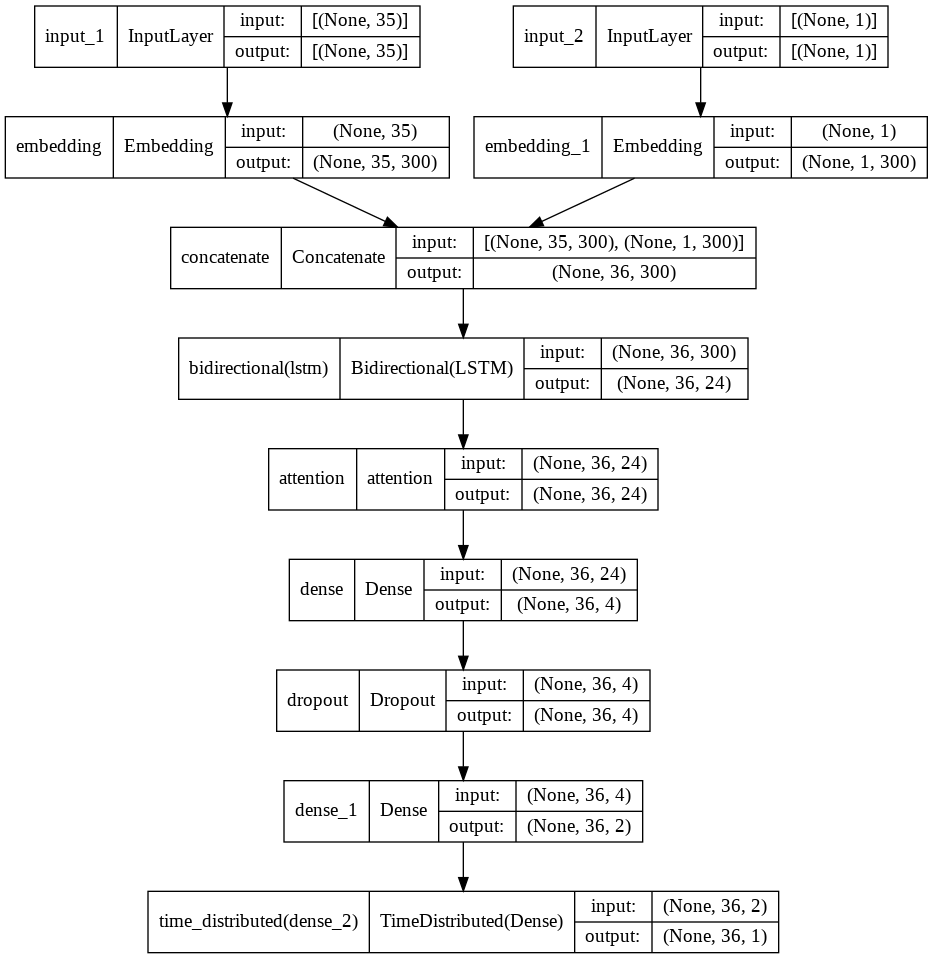

In [ ]:
maxlen = 300
max_features = 5000
embedding_dims = 100
rnn_dims = 50
batch_size = 1000
input_text_layer = Input(shape = (35,))
emb_layer_text = Embedding(vocab_size,300,input_length=max_length,weights=[embs])(input_text_layer)
#pool_text_layer = GlobalAveragePooling1D()(emb_layer_text)

input_sentiment_layer = Input(shape =(1,))
emb_layer_sentiment= Embedding(4,300,input_length=1 )(input_sentiment_layer)
#flat_layer = Flatten()(input_sentiment_layer)

concat_layer= Concatenate(axis = 1)([emb_layer_text,emb_layer_sentiment])
lstm_layer1 = Bidirectional(LSTM(12, activation="sigmoid", return_sequences=True))(concat_layer)

#Attention
from tensorflow.keras.activations import  tanh
from tensorflow.keras.backend import dot
from tensorflow.keras.activations import softmax
from tensorflow.keras.backend import sum
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding,Dense,Dropout,Concatenate,Flatten,TimeDistributed,Input,GRU,BatchNormalization,Bidirectional,SpatialDropout1D,LSTM,LayerNormalization
from tensorflow.keras.regularizers import l2
class attention(tf.keras.layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super().__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = tanh(dot(x,self.W)+self.b)
        a =  tf.nn.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return  tf.reduce_sum(output, axis=1)

#End attention

att = attention(return_sequences=True)(lstm_layer1)
dense1 = Dense(4,activation='relu',kernel_regularizer=l2(0.0001))(att)
dp = Dropout(0.5)(dense1)
dense1 = Dense(2,activation='relu',kernel_regularizer=l2(0.0001))(dp)
output=TimeDistributed(Dense(1,activation='sigmoid'))(dense1)


model = Model(inputs=[input_text_layer,input_sentiment_layer], outputs=[output])

model.compile(loss= my_loss, optimizer="adam",metrics=["accuracy"])

#for each in model.layers:
#  if(type(each) == tf.keras.layers.Embedding):
#    each.trainable = False
print (model.summary())
mc = ModelCheckpoint("best_checkpoint.h5", monitor="val_accuracy" , save_best_only=True, save_weights_only=True)
#mc = ModelCheckpoint("best_checkpoint.h5", monitor="val_accuracy" , save_best_only=True, save_weights_only=True)
tf.keras.utils.plot_model(model, show_shapes=True)
#model.fit(X_train,y_train,validation_data=(X_val,y_val), epochs= 20, batch_size=50, callbacks=[mc])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
label_train.shape

(19236, 36)

In [ ]:
model.fit([train_padded,train_sentiment],label_train,validation_data=([val_padded,val_sentiment],label_val), epochs= 20, batch_size=128,callbacks=[mc])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
151/151 [==============================] - 64s 424ms/step - loss: 0.6202 - accuracy: 0.8017 - val_loss: 0.5341 - val_accuracy: 0.8011
Epoch 2/20
151/151 [==============================] - 61s 403ms/step - loss: 0.5051 - accuracy: 0.8017 - val_loss: 0.4460 - val_accuracy: 0.8011
Epoch 3/20
151/151 [==============================] - 61s 402ms/step - loss: 0.4517 - accuracy: 0.8017 - val_loss: 0.3937 - val_accuracy: 0.8011
Epoch 4/20
151/151 [==============================] - 61s 404ms/step - loss: 0.4019 - accuracy: 0.8017 - val_loss: 0.3412 - val_accuracy: 0.8011
Epoch 5/20
151/151 [==============================] - 60s 399ms/step - loss: 0.3689 - accuracy: 0.8017 - val_loss: 0.3192 - val_accuracy: 0.8011
Epoch 6/20
151/151 [==============================] - 62s 409ms/step - loss: 0.3539 - accuracy: 0.8017 - val_loss: 0.3093 - val_accuracy: 0.8011
Epoch 7/20
151/151 [==============================] - 58s 387ms/step - loss: 0.3462 - accuracy: 0.8017 - val_loss: 0.3029 - val_ac

In [ ]:
train_pred = model.predict([train_padded,train_sentiment])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
train_pred[0]

array([[4.2103004e-01],
       [3.8363233e-01],
       [3.6796674e-01],
       [3.5314298e-01],
       [3.4257853e-01],
       [4.1066560e-01],
       [2.2805035e-03],
       [2.2640824e-03],
       [2.2595823e-03],
       [2.2572875e-03],
       [2.2582412e-03],
       [2.2568703e-03],
       [2.2552907e-03],
       [2.2549033e-03],
       [2.2557974e-03],
       [2.2544563e-03],
       [2.2505224e-03],
       [2.2545457e-03],
       [2.2515953e-03],
       [2.2512376e-03],
       [2.2519529e-03],
       [2.2513568e-03],
       [2.2494197e-03],
       [2.2448003e-03],
       [2.2464991e-03],
       [2.2478700e-03],
       [2.2512674e-03],
       [2.2528768e-03],
       [2.2577941e-03],
       [2.2873878e-03],
       [2.3180544e-03],
       [2.3494661e-03],
       [2.4155378e-03],
       [2.5438666e-03],
       [2.4707913e-03],
       [7.2574971e-05]], dtype=float32)

In [ ]:
def ind2word(preds):
  index2word = {i:w for w,i in word_index.items()}
  selected_text = []
  for s in preds:
    words = []
    for j in s:
      try:
        word = index2word[j]
        words.append(word)
      except:
        continue
    selected_text.append(words)
  return selected_text 

In [ ]:
train_pred1 = np.squeeze(train_pred)
train_pred1 = np.where(train_pred1>0.2,1,0)
train_preds_ind =convert_label_matrix_to_ind(train_padded,train_pred1)
train_extracted_text = ind2word(train_preds_ind)
train_selected_text = tse_st.Map_Extracted(preprocessed_train_X,train_extracted_text)
tse_st.score(train_selected_text,train_y_ex)

0.586870934442255

In [ ]:
val_pred = model.predict([val_padded,val_sentiment])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
val_pred1 = np.squeeze(val_pred)
val_pred2 = np.where(val_pred1>0.2,1,0)
val_preds_ind =convert_label_matrix_to_ind(val_padded,val_pred2)
val_extracted_text = ind2word(val_preds_ind)
val_selected_text = tse_st.Map_Extracted(preprocessed_val_X,val_extracted_text)
tse_st.score(val_selected_text,val_y_ex)

0.5552476343798777

In [ ]:
train_preds_ind[0:5]

[[549, 623, 13, 1247, 1248],
 [689],
 [2,
  101,
  2,
  600,
  261,
  178,
  174,
  212,
  42,
  5,
  141,
  518,
  19,
  499,
  15,
  94,
  49,
  1980,
  1138,
  13,
  5,
  162,
  12],
 [479, 62, 16, 458, 12, 4, 204],
 [93, 25, 31, 15, 251, 10]]

In [ ]:
train_extracted_text = ind2word(train_preds_ind)
train_extracted_text[0:5]

[['st', 'present', 'for', 'senior', 'board', 'fml'],
 ['yummi', 'save', 'me', 'some', 'pleas', 'lol'],
 ['i',
  'wish',
  'i',
  'knew',
  'someon',
  'down',
  'there',
  'who',
  'could',
  'hook',
  'us',
  'up',
  'a',
  'friend',
  'told',
  'me',
  'onc',
  'that',
  'they',
  'got',
  'crappi',
  'seat',
  'for',
  'a',
  'show',
  'in'],
 ['lucki', 'u', 'im', 'stuck', 'in', 'the', 'rain'],
 ['he', 'just', 'not', 'that', 'into', 'you']]

In [ ]:
#val_padded = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating=trunc_type)

In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)
compare_df = pd.DataFrame(data ={'origin':train_X_df.text,'selected_text':train_selected_text ,'true_text':train_y_ex, 'sentiment':train_X_df.sentiment})
compare_df
#compare_df.loc[compare_df.sentiment == 'positive',:]

In [ ]:
label_train[0]

NameError: ignored

In [ ]:
val_selected_text[0:10]

['I hope she was okay. I never her heard her say her tummy hurt.',
 'aww shock mother`s day',
 'hospital. Doc says I`ll',
 'boo you can come over and we`ll watch and braid each others hair.',
 'Lost at bowling again why do i suck',
 'Bonjour Twitterland',
 'i ill never have it but the sad thing is that u didn`t put an Alternate e-mail!! cause if u dont remember ur secret',
 'watching matilda with a bowl of noodles',
 'Thanks Amy! That video is so awesome! you He`s amazing that too!!',
 'im sad about missing out on the to be in new video.']

## BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.0 MB/s 
     |████████████████████████████████| 895 kB 35.6 MB/s 
     |████████████████████████████████| 61 kB 412 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer
from keras.models import Model
from keras.callbacks import ModelCheckpoint
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:

import tensorflow as tf
import pandas as pd

In [ ]:
model = tf.keras.load_weights('my_checkpoint.h5')

AttributeError: ignored

### 2.4 Huấn luyện trên train + val

In [ ]:
model_full = bayes_extraction(k=15, z_pos = 0.00003 )

In [ ]:
preprocessed_X_df, cleaned_X_df = preprocess_tweets(X_df)
preprocessed_y_ex = _preprocessed_y_ex(X_df,y_ex)
model_full.fit(preprocessed_X_df,preprocessed_y_ex)

bayes_extraction(k=15, z_pos=3e-05)

## 3. Rút trích text trên tập test:

In [ ]:
test_df = pd.read_csv('Applied-Data-Science-Group-7/test.csv')
test_df

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep but i try it",negative
3530,416863ce47,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",positive
3531,6332da480c,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,negative
3532,df1baec676,_sutra what is your next youtube video gonna be about? I love your videos!,positive


In [ ]:
test_preprocessed,cleaned_test_df = preprocess_tweets(test_df)

In [ ]:
preds_extracted_text = model_full.extract(test_preprocessed)
preds_extracted_text[0:5]

['Last session of the day http://twitpic.com/67ezh',
 'exciting Good',
 'Recession shame!',
 'happy',
 '']

## 4. Submission

In [ ]:
submission_df = pd.DataFrame(data = {'textID': test_df.textID,'selected_text':pd.Series(preds_extracted_text)})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
submission_df.head(5)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting Good
2,eee518ae67,Recession shame!
3,01082688c6,happy
4,33987a8ee5,


In [ ]:
# y_test = test_df.sentiment.map({'positive':1,'neutral':0,'negative':-1}).to_list()
# tweets_test = test_df.text.to_list()

In [ ]:
#Extract_text(y_test,preprocessing(tweets_test),likelihood)

In [ ]:
# submission = pd.DataFrame(data ={'textID': test_df.textID,'selected_text':pd.Series(extracted_text)})
# predict